The sum of squares of independent standard normal random variables follows a chi-squared distribution.  As $n \to \infty$, with fixed $p$, a binomial distribution will approach a normal distribution in shape.

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)

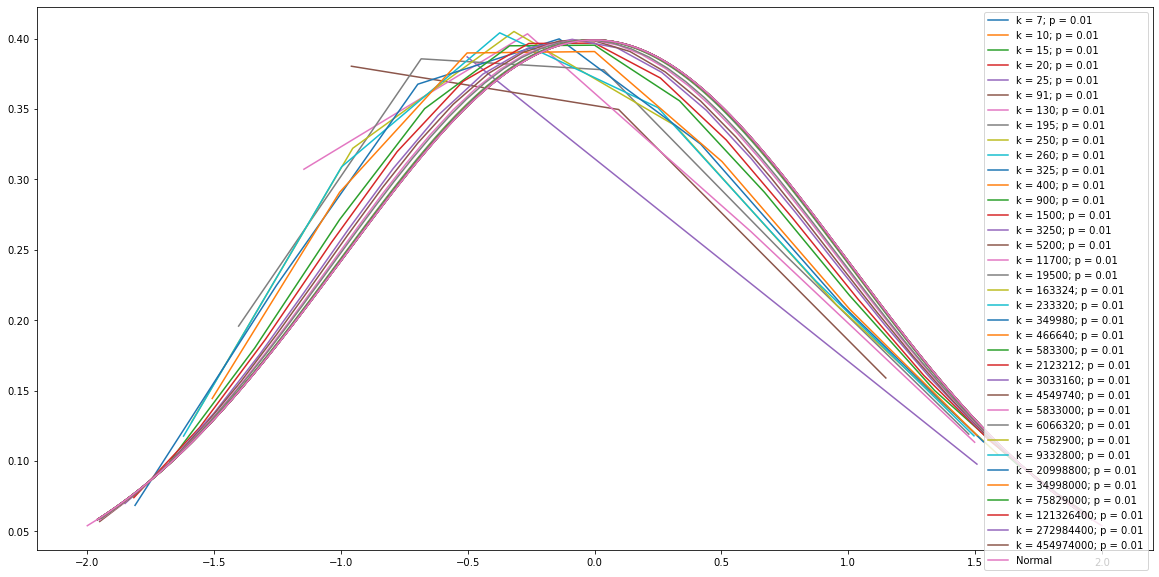

In [114]:
ks = [7, 10, 15, 20, 25, 250, 400, 900, 1500]
ks += [k*13 for k in ks]
ks += [k*23332 for k in ks]
ks.sort()

p = 0.01 # np.random.uniform(0, 1)

errs = list()

for i, k in enumerate(ks):
    
    # generate random variable
    rv = scipy.stats.binom(k, p)
    mean, var, skew, kurtosis = rv.stats(moments='mvsk')

    # sample pmf and normalize
    _x = np.arange(int(rv.ppf(.025)), int(rv.ppf(0.975)))
    y = rv.pmf(_x)

    # plot
    scale = np.sqrt(var)
    px = (_x-mean)/scale # center x values on 0; scale by variance
    py =  y*scale        # since x scaled down by sqrt(var), y must scale up by sqrt(var) (s.t. integral over X is still 1)
    plt.plot(px, py, label=f'k = {k}; p = {round(p, 2)}')

    errs.append(np.linalg.norm(py - scipy.stats.norm().pdf(px))**2/len(px))

# plot standard normal for reference
_xo = np.linspace(-2, 2, 100)
y = scipy.stats.norm().pdf(_xo)
plt.plot(_xo, y, label='Normal')

plt.legend()

Text(0.5, 1.0, 'MSE vs k for p=0.01 (log scale)')

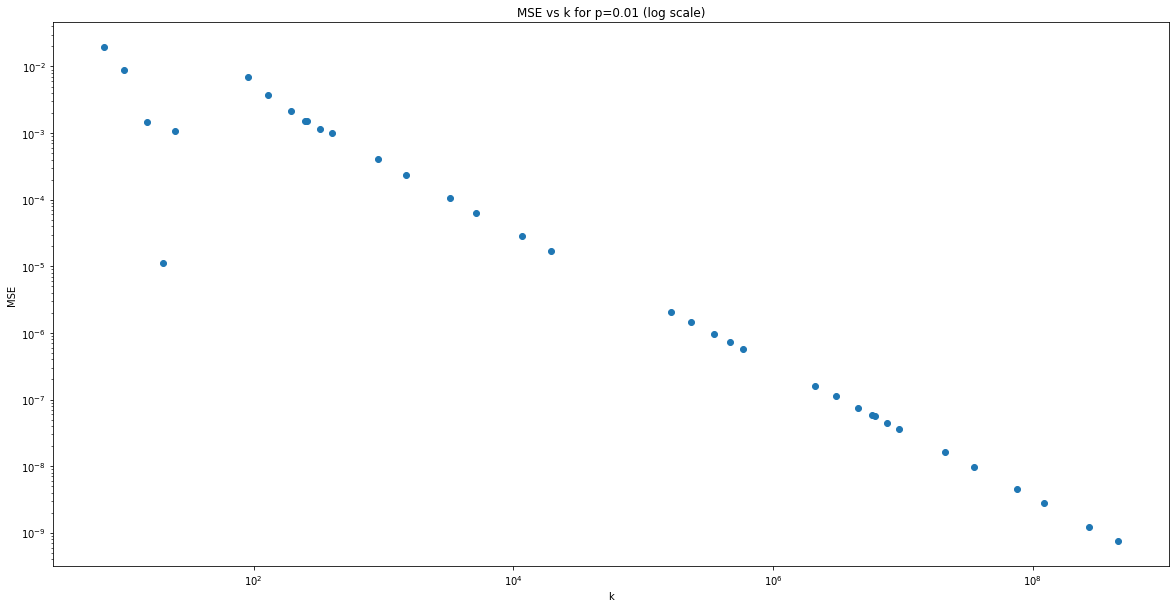

In [115]:
fig, ax1 = plt.subplots()
ax1.scatter(ks, errs, label='MSE of sampled points')
ax1.set_yscale('log'), ax1.set_xscale('log')
ax1.set_ylabel('MSE'), ax1.set_xlabel('k')
plt.title(f'MSE vs k for p={round(p, 2)} (log scale)')

##### This argument [can be extended](https://ocw.mit.edu/courses/mathematics/18-443-statistics-for-applications-fall-2003/lecture-notes/lec23.pdf) to derive the chi-squared distribution for Pearson's test statistic.

In [167]:
def pearsons_stat(x, p):
    assert len(x) == len(p)
    N = np.array(x).sum()
    stat = N*sum([ (_x/N - _p)**2/_p for _x, _p in zip(x, p) ])
    pval = 1-scipy.stats.chi2(df=len(x)-1).cdf(stat)
    return dict(statistic=stat, pvalue=pval)

In [296]:
# x = np.array([12, 31, 44, 11, 4])
p = np.array([.2, .2, .2, .2, .2])
p_real = p + abs(np.random.normal(size=(len(p),)))
p_real = p_real/p_real.sum()
x = np.random.multinomial(100, pvals=p_real)
N = x.sum()

In [297]:
print(scipy.stats.chisquare(f_obs=x, f_exp=p*N))
print(pearsons_stat(x, p))

Power_divergenceResult(statistic=83.7, pvalue=2.862376506004529e-17)
{'statistic': 83.7, 'pvalue': 0.0}


<br>

### What sample size is needed to detect small variations in group frequency?

In [289]:
data = list()
for ke in np.linspace(1, 7, 20):

    k = int(10**ke)
    
    # range for noise; easier to detect differences when variations in group frequencies are greater
    for sigma in np.linspace(0.001, 0.02, 5):
        for _ in range(50):

            # start with equal likelihoods
            p = np.array([.2, .2, .2, .2, .2])

            # randomly change the likelihoods and scale to [0,1], sum to 1
            p_real = p + sigma*np.random.normal(size=(len(p),))
            p_real -= min([p_real.min(), 0])
            p_real = p_real/p_real.sum()
            
            # generate sample data
            x = np.random.multinomial(k, pvals=p_real)

            # test with equal likelihoods
            res = pearsons_stat(x,p)

            # track results
            res['k'] = k
            res['sigma'] = sigma
            data.append(res)

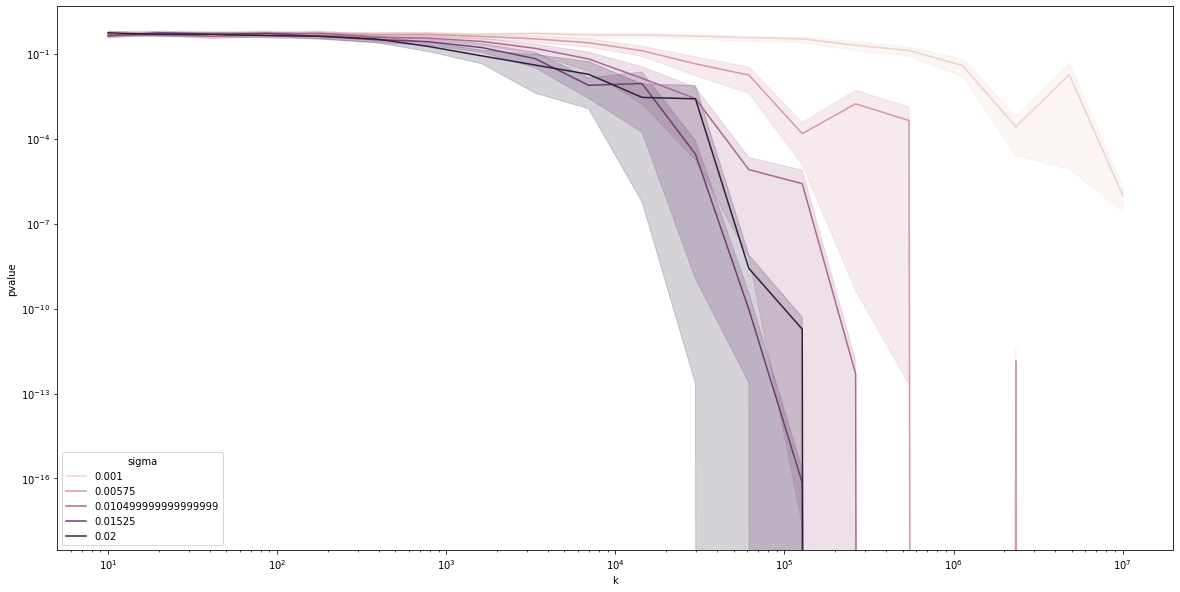

In [291]:
# as the sample size increases, pvalues become small such that small variations in group frequencies can be detected with confidence
df = pd.DataFrame(data)
sns.lineplot(x="k", y="pvalue",
             hue="sigma", 
            # style="event",
             data=df)
plt.yscale('log')
plt.xscale('log')

### Chi-square test for homogeneity
Suppose $X_1, X_2$ are independent samples of size $n_1, n_2$ from two multinomial distributions, each with $k$ possible outcomes.  Let $p_{ij}$ be the frequency of $X_i$ having outcome $j \in \{1, ... k\}$.  Design a test to see whether $p_{1j} = p_{2j}$.

In [334]:
def homogeneity_stat(xx, p):

    sum_args = list()
    for xj in xx:
        assert len(xj) == len(p)
        nj = xj.sum()
        sum_arg = sum([ (xij - nj*pi)**2/(nj*pi) for xij, pi in zip(xj, p) ])
        sum_args.append(sum_arg)
    
    stat = sum(sum_args)
    pval = 1-scipy.stats.chi2(df=len(p)-1).cdf(stat)
    return dict(statistic=stat, pvalue=pval)

In [363]:
# number of possible outcomes (i.e. number of groups)
k = 3
n1 = 30
n2 = 15

# get p1
p1 = np.random.uniform(0, 1, size=k)
p1 = p1/p1.sum()

# underlying H0 truth value
h0 = np.random.choice([True, False])

# generate p2
if h0:
    p2 = p1.copy()
else:
    p2 = np.random.uniform(0, 1, size=k)
    p2 = p2/p2.sum()

# generate X1, X2
x1 = np.random.multinomial(n1, pvals=p1)
x2 = np.random.multinomial(n2, pvals=p2)

# under H0, p1j = p2j
x0 = x1 + x2
n0 = x0.sum()
p0 = x0/n0

# compute homogeneity stat
stat = homogeneity_stat(
    xx=[x1, x2],
    p=p0
)

print(f'H0: {h0}')
print(stat)

H0: False
{'statistic': 11.25, 'pvalue': 0.0036065631360157058}
